###  1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from tqdm.auto import tqdm
%matplotlib inline

In [4]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project_my/Проект_2_groups.csv', sep=';')
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project_my/Проект_2_group_add.csv', 
                         sep=',')
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project_my/Проект_2_active_studs.csv',
                          sep=';')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project_my/Проект_2_checks.csv', sep=';')

Посмотрим на входные данные

***Таблица groups***

In [5]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.dtypes

id      int64
grp    object
dtype: object

In [7]:
groups.shape #количество записей

(74484, 2)

In [8]:
groups.nunique() #уникальных значений

id     74484
grp        2
dtype: int64

In [9]:
groups.duplicated().sum() #количество дупликатов

0

In [10]:
groups.isna().sum() #количество пустых строк

id     0
grp    0
dtype: int64

***Таблица groups_add***

In [11]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [13]:
groups_add.shape

(92, 2)

In [14]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [15]:
groups_add.duplicated().sum() 

0

In [16]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

***Таблица active_studs***

In [17]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
active_studs.dtypes

student_id    int64
dtype: object

In [19]:
active_studs.shape

(8341, 1)

In [20]:
active_studs.nunique()

student_id    8341
dtype: int64

In [21]:
active_studs.duplicated().sum() 

0

In [22]:
active_studs.isna().sum()

student_id    0
dtype: int64

***Таблица checks***

In [23]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [24]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [25]:
checks.shape

(541, 2)

In [26]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [27]:
checks.duplicated().sum() 

0

In [28]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Соединю дополнительный файл groups_add с groups и посмотрю на распределение пользователей по группам

In [29]:
groups_total = pd.concat([groups, groups_add])
groups_total.shape

(74576, 2)

In [30]:
#распределение по группам
groups_total.grp.value_counts().sort_values()

A    14693
B    59883
Name: grp, dtype: int64

Таким образом, у нас всего 74576 пользователей и распределение по группам явно неравномерное.\
Проверим все ли пользователи заходили в приложение и совершали оплату, так как посещение сайта является условием для использования новой механики оплаты.

In [31]:
#количество активных пользователей, не вошедших в общий список
active_studs.query('student_id not in @groups_total.id').shape[0]

0

In [32]:
#количество совершивших оплату пользователей, но отсутствующих в общем списке
checks.query('student_id not in @groups_total.id').shape[0]

0

In [33]:
#количество совершивших оплату пользователей, отсутствующих в списке активных в дни проведения теста
checks.query('student_id not in @active_studs.student_id').shape[0]

149

Видим, что в период проведения экспериментов были оплаты и от тех студентов (149), которые не посещали платформу. Возможно, это автоматические оплаты или сбой в системе. \
Посмотрим на распределение групп в checks и active_studs:

In [34]:
#распределение активных пользователей по группа
groups_total.query('id in @active_studs.student_id').grp.value_counts().sort_values()

A    1538
B    6803
Name: grp, dtype: int64

In [35]:
#совершившие оплату в группах
groups_total.query('id in @checks.student_id').grp.value_counts()

B    434
A    107
Name: grp, dtype: int64

In [36]:
groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts() 
#распределение активных  и совершивих оплату пользователей, всего 392

B    314
A     78
Name: grp, dtype: int64

#### Промежуточный вывод 
* Пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.
* У нас 74576 пользователей, из них 8341 являются активными, 541 совершили оплату. Из общего количества совершивших оплату (541), 392 являются активными - оплатившими. Не ясно, это сбой системы или автоматические платежи , поэтому не стану включать этих пользователей в AB-тест.

Я буду проверять гипотезы на активных и совершивших оплату пользователей, так как нецелесообразно проверять гипотезы эксперимента на пользователях, которые были отобраны, но в нем не участвовали
#### Объединим все таблицы в один df и отфильтруем пользователей для AB-теста

In [37]:
active_checks = (
                active_studs
                .merge(checks, how='left', on='student_id')
                .rename(columns={'student_id': 'id'})
                )
active_checks.query('rev.notna()').head() #список активных пользователей со списком оплативших

,id,rev
62,1184303,1530.0000
67,3354191,1900.0001
77,3278734,1900.0000
99,720651,1980.0000
193,1232221,1900.0000


In [38]:
#объединим активных оплативших из предыдущего шага с groups_total, оставив только активных
active_total = groups_total.merge(active_checks, how='right', on='id')

In [39]:
#активные пользователи группы А
group_a = active_total.query('grp == "A"')
group_a.head()

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
3,4238589,A,NaN
7,1394612,A,NaN
21,5194768,A,NaN


In [40]:
#активные и совершившие оплату пользователи группы А
group_a_paid = group_a.query('rev > 0')
group_a_paid.head()

,id,grp,rev
62,1184303,A,1530.0
99,720651,A,1980.0
306,4337103,A,580.0
392,332387,A,2910.0
439,1659434,A,690.0


In [41]:
#активные пользователи группы B
group_b = active_total.query('grp == "B"')
group_b.head()

,id,grp,rev
2,3276743,B,NaN
4,4475369,B,NaN
5,5481015,B,NaN
6,1353433,B,NaN
8,1170611,B,NaN


In [42]:
#активные и совершившие оплату пользователи группы B
group_b_paid = group_b.query('rev > 0')
group_b_paid.head()

,id,grp,rev
67,3354191,B,1900.0001
77,3278734,B,1900.0000
193,1232221,B,1900.0000
195,3821501,B,1900.0000
211,1036096,B,1900.0000


<AxesSubplot:xlabel='rev', ylabel='Count'>

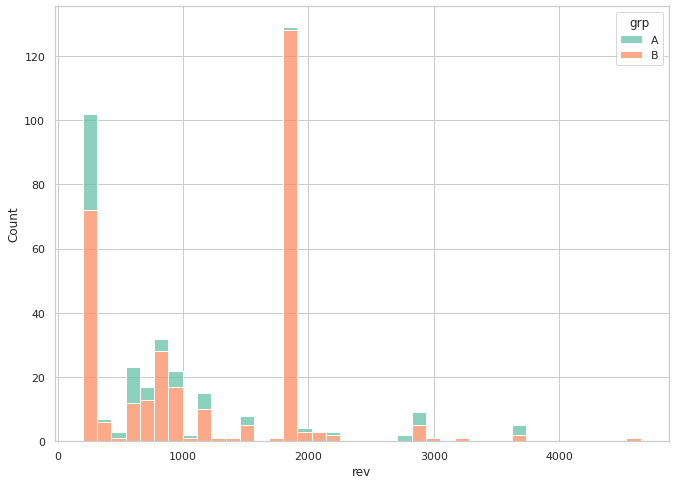

In [43]:
#посмотрим на распределение оплат активных пользователей
sns.set(rc={'figure.figsize' : (11, 8)}, style="whitegrid", palette="Set2") #установлю размеры и стиль
sns.histplot(data=active_total, x='rev', hue='grp', bins=39, multiple="stack")

Видим неравномерное распределение, посмотрим на выбросы с помощью боксплот

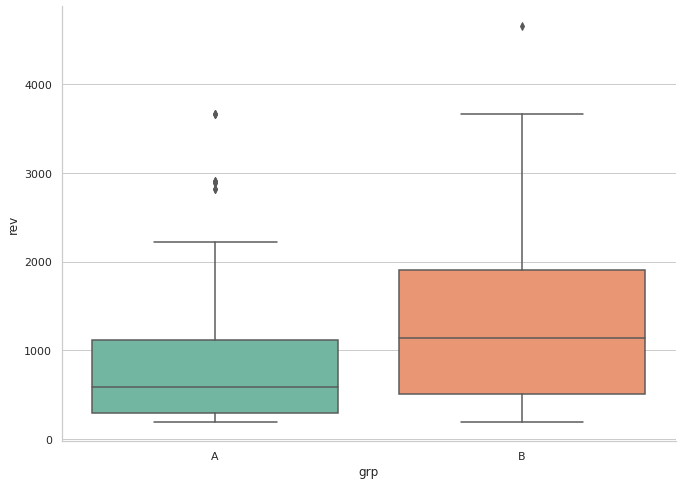

In [44]:
#посмотрим на выборосы:
sns.boxplot(data=active_total, y='rev', x='grp')
sns.despine()

Из боксплот мы видим, что в наших данных есть выбросы, распределения оплат выглядят не равномерными, не унимодальными.\

В нашем случае, где присутствует оплата и проверяется новая механика оплаты, будет неправильным удалять выбросы, так как мы можем удалить из анализа клиентов с большими суммами оплат.

Так же из-за выбросов сравнение средних в наших выборках будет некорректно. Значит, применение Т-критерия, который сравнивает средние в распределениях, а выбросы сильно влияют на значение среднего, будет неправильным.

#### Сформулирю предварительную гипотезу

* H0 - Новая механика оплаты услуг на сайте в группе B не отличается от базовой механики котрольной группы A.
* H1 - Новая механика оплаты услуг на сайте в группе B имеет значимые различия в сравнении с базовой механикой в группе A.

#### Выберу метрики

Так как у нас есть две категориальные переменные - принадлежность к группе и факт оплаты (1 или 0)-  следует проверить коэффициент конверсии в целевое действие, а конкретно в оплату услуги на сайте (CR). Также проверим степень воздействия новой механики оплаты на среднее значение суммы оплаты (ARPPU). Ещё посчитаю ARPU вместе с ARPPU для просмотра степени воздействия на всех активных пользователей. \
Таким образом:

* CR в оплату (сonversion rate) — отношение количества платящих пользователей к общему количеству пользователей.\
Переход в оплату услуги. CR будет выше в том варианте, где пользователю проще проивзести оплату.

* ARPU - отношение всей выручки на количество активных пользователей.

* ARPPU - отношение выручки на количество активных оплативших пользователей. 

In [45]:
#построим наглядную таблицу 
metrics = pd.DataFrame()
metrics['students'] = active_total.groupby('grp').id.count()  #количество активных пользователей
metrics['paying_students'] = active_total.groupby('grp').rev.count() #количество совершивших оплату
metrics['CR'] = round(active_total.groupby('grp').rev.count() / active_total.groupby('grp').id.count() *100, 2) #конверсия 
metrics['average_check'] = round(active_total.groupby('grp').rev.mean(), 2) #средний чек
metrics['repeat_purchases'] = active_total.groupby('grp').rev.count() / active_total.query('rev.notna()')\
                                          .groupby('grp').rev.count() #повторные покупки
metrics['arppu'] = round(metrics['repeat_purchases'] * active_total.groupby('grp').rev.mean(), 2) #ARPPU
metrics['arpu'] = round(metrics['CR']*metrics['arppu'], 2) #ARPU
metrics

,students,paying_students,CR,average_check,repeat_purchases,arppu,arpu
A,1538,78,5.07,933.59,1.0,933.59,4733.30
B,6803,314,4.62,1257.88,1.0,1257.88,5811.41


#### Имеются ли различия в показателях и с чем они могут быть связаны?
* Опять же видим, как пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.
* Наблюдаем небольшой отрицательный эффект CR (конверсия в покупку у группы А больше, чем у группы В), и положительные эффекты в ARPU и ARPPU. То есть, конверсия падает, но доход на пользователя/покупателя растёт. Такое может происходить, если пользователь попадает на сайт и начинает осуществлять ряд целевых действий. Конечный этап заключается в оплате услуги. До момента перехода пользователя на этап оплаты, новая механика оплаты не оказывает на него влияния, либо как в нашем случае конверсия перехода в оплату упал на 0.45 пунктов. Но когда пользователь совершил целевое действие и перешел на следующий этап (хочет оплатить услугу), то новая механика начинает работать. Причем в данном случае положительно, так как средний чек увеличился. Но этого не додостаточно, и отрицательные и положительные различия в показателях требуют статистических подтверждений.
* ARPPU ожидаемо равна среднему чеку, так как на каждого совершившего оплату пользователя приходится по одной покупке (повторных покупок не было).

#### Являются ли эти различия статистически значимыми?
Для проверки стат значимости различий я выберу bootstrap, так как нет объективных причин НЕ использовать его. Объем данных ползволяет, размеры групп очень сильно отличаются, поэтому классические тесты могут давать большие погрешности. В таких случаях идеально подходит bootstrap. Гавным критерием будет, чтобы доверительный интервал не включал в себя 0

* Строим bootstrap распределения для групп А и B.
* Вычислим их разницу.
* В получившемся рапределении разницы находим доверительных интервал.
* Проверяем, попадает ли доверительный интервал в 0. Если да, то нулевая гипотеза на данном уровне значимости принимается, если нет - отвергается.

Напишем функцию, которая позволит проверять гипотезы с помощью bootstrap:

In [111]:
# функция для проверки гипотез с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения контрольной выборки
    data_column_2,                       # числовые значения целевой выборки
    col_1,                               #название колонки первой выборки
    col_2,                               #название колонки второй выборки
    sample_count_1 = 0,                  #количество наблюдений для подвыборок
    sample_count_2 = 0,                  #количество наблюдений для подвыборок
    boot_it = 10000,                     #количество бутстрэп-подвыборок
    statistic = 'mean',                  #интересующая нас статистика
    bootstrap_conf_level = 0.95,         #уровень значимости
    replace = True,                      #параметр возвращения
    max_len = True
):
    from scipy.stats import norm
    
    if sample_count_1 == 0:
        sample_count_1 = len(data_column_1[col_1])
    
    if sample_count_2 == 0:
        sample_count_2 = len(data_column_1[col_2])
    if max_len:
        boot_len = max([sample_count_1, sample_count_2])
    else:
        boot_len = min([sample_count_1, sample_count_2])
    
    boot_data = []
    smpl_1_data = []
    smpl_2_data = []
    for i in tqdm(range(boot_it)):         #извлекаем подвыборки
        if statistic == 'arpu':
            samples_1 = arpu(data_column_1.sample(boot_len, replace=replace))
            samples_2 = arpu(data_column_2.sample(boot_len, replace=replace))            
        else:
            samples_1 = np.nanmean(data_column_1[col_1].sample(boot_len, replace=replace).values)
            samples_2 = np.nanmean(data_column_2[col_2].sample(boot_len, replace=replace).values)
        
        
        boot_data.append(samples_1-samples_2)
        smpl_1_data.append(samples_1)
        smpl_2_data.append(samples_2)
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    # доверительный интервал 
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.nanmean(boot_data), 
        scale = np.nanstd(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.nanmean(boot_data), 
        scale = np.nanstd(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    #настройка визуализации
    _, _, bars = plt.hist(pd_boot_data[0], bins = 30)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('lightcoral')
        else: 
            bar.set_facecolor('steelblue')
            bar.set_edgecolor('lightskyblue')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of bootstrap")
    plt.show()
    
    print('pvalue = ', p_value)
       
    return {"boot_data" : boot_data, 
            "quants" : quants, 
            "p_value" : p_value,
           "smpl_1_data" : smpl_1_data,
           "smpl_2_data" : smpl_2_data}

Определим функции для метрик. \
Для CR в качестве аргумента нужно будет передавать серию о факте оплаты со значениями  1 и 0, или True и False. В функции ARPPU нужно будет передавать серию, где отобраны только платежи.

In [103]:
#определим функции для метрик
def cr_func(x):
    return sum(x) / len(x)

def arpu_func(x):
    return np.mean(x)

def arppu_func(y):
    return np.mean(y)

**Бутстрап по CR** \
Гипотеза:\
Н0: Конверсия в оплату в двух группах не отличается \
Н1: Конверсия в оплату в двух группах отличается

In [104]:
#добавим колонку со статусом оплаты (0 - не оплачен, 1 - оплачен):
active_total['payment'] = active_total.rev.apply(lambda x: 0 if np.isnan(x) else 1) 
active_total.query('rev.isna()').head()

,id,grp,rev,payment
0,581585,A,NaN,0
1,5723133,A,NaN,0
2,3276743,B,NaN,0
3,4238589,A,NaN,0
4,4475369,B,NaN,0


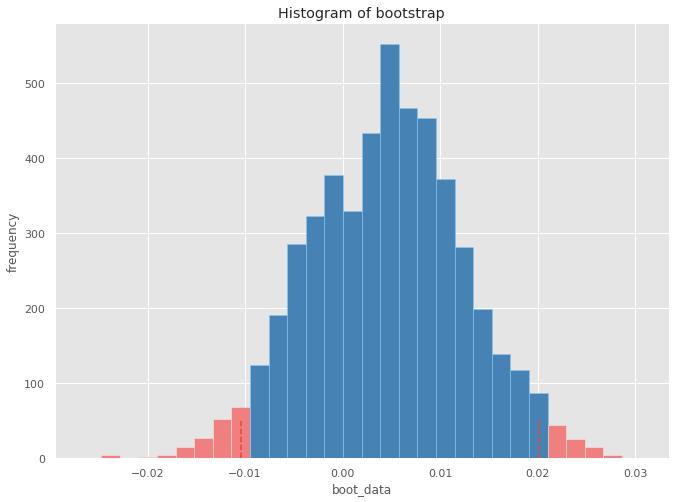

pvalue =  0.5650643760546425


In [112]:
cr_boot = get_bootstrap(data_column_1 = active_total.query('grp == "A"'), col_1 = 'payment',
                        data_column_2 = active_total.query('grp == "B"'), col_2 = 'payment',
                        boot_it = 5000,
                        statistic = 'cr_func')

Группы всё-таки не отличаются друг от друга. Это видно по доверительному интервалу, который попадает в 0. Недостаточно оснований отвергнуть нулевую гипотезу. Нельзя утверждать, что различия CR в двух группах есть.

**Бутстрап по ARPU**\
Гипотеза:\
Н0: ARPU в двух группах не отличается \
Н1: ARPU в двух группах отличается

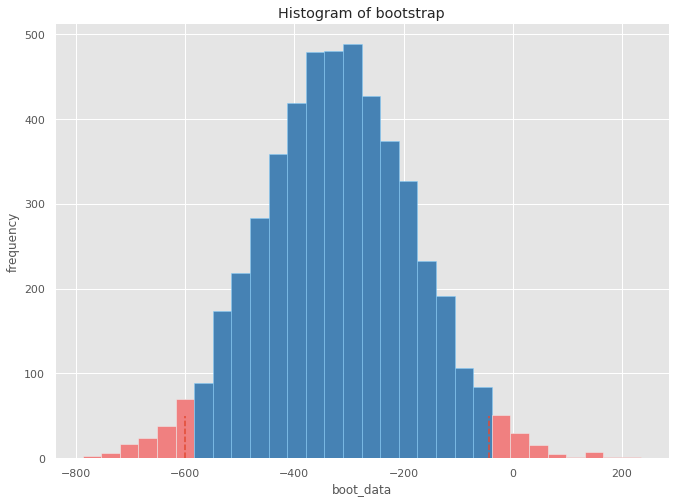

pvalue =  0.02177110717135273


In [113]:
arpu_boot = get_bootstrap(data_column_1 = group_a, col_1 = 'rev',
                        data_column_2 = group_b, col_2 = 'rev',
                        boot_it = 5000,
                        statistic = 'arpu_func')

**Вывод по бутстрапу по ARPU**:\
0 не попадает в доверительный интервал. Отвергаем нулевую гипотезу. ARPU в двух группах различаются.

**Бутстрап ARPPU**\
Гипотеза:\
Н0: ARPPU в двух группах не отличается \
Н1: ARPPU в двух группах отличается

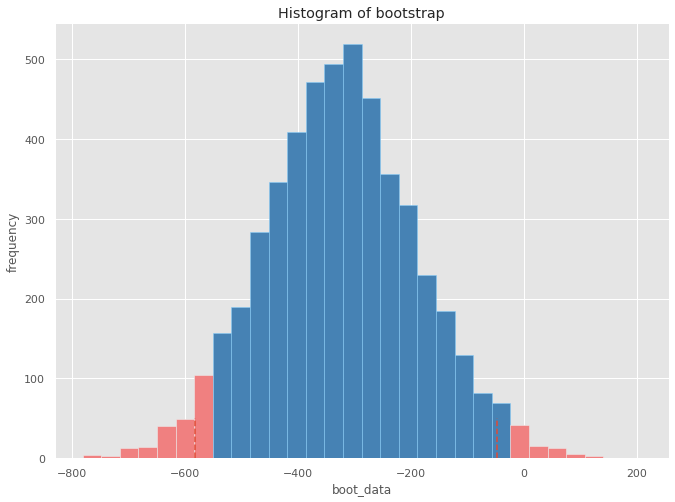

pvalue =  0.016688592241146598


In [114]:
arppu_boot = get_bootstrap(data_column_1 = group_a_paid, col_1 = 'rev',
                        data_column_2 = group_b_paid, col_2 = 'rev',
                        boot_it = 5000,
                        statistic = 'arppu_func')

**Вывод по бутстрапу по ARPPU**:\
Доверительный интервал не включает в себя 0. Отвергаем нулевую гипотезу. ARPPU в двух группах различаются. Очень малое количество наблюдений из двух выборок пересекаются между собой.

#### Стоит ли запускать новую механику на всех пользователей?
Напомним основные гипотезы:
* H0 - Новая механика оплаты услуг на сайте в группе B не отличается от старой механики, оставленной в группе A.
* H1 - Новая механика оплаты услуг на сайте в группе B имеет значимые различия в сравнении с механикой в группе A. \

Напомним выводы по тестам:
* Бутстрап по CR показал pvalue > 0.05. Это не дало нам основания отвергнуть нулевую гипотезу.
* Бутстрап по ARPU показал pvalue < 0.05. Есть основания отвергнуть нулевую гипотезу.
* Бутстрап по ARPPU показал pvalue < 0.05. Это дает нам основания отвергнуть нулевую гипотезу.

Таким образом, согласно проведенным тестам  новая механика оплаты даёт статистически значимый прирост в метриках ARPU и ARPPU. Имеет смысл применить новую механику оплаты услуг на всех пользователей. При этом в дальнейшем следить за метриками. Особенно за коэффициентом конверсии перехода к оплате. \
Однако стоит еще отметить, что так как система сплитования делит пользователей на группы неравномерно, в результате мы тестируем изменения на 85% наших активных пользователей. В будущем неудачный эксперимент в таком объеме может привести к значительному падению выручки.\
В идеале нужно было выделить больше пользователей для группы А, потому что из-за малого количества уникальных пользователей в группе А мы можем столкнуться с ситуацией, когда тесты показали статистически значимые различия, а в генеральной совокупности эти различий может не оказаться, либо различия будут в пользу базовой механики оплаты услуг на сайте.

### 2. SQL

#### 2.1 Очень усердные ученики
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. \
NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [25]:
import pandahouse as ph

In [24]:
#Установим соединение с Clickhouse
connection_default = {'host': 'https://clickhouse.lab.karpov.courses/',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [29]:
query_1 = """
    SELECT COUNT(DISTINCT st_id) AS hardworking_students         --- считаем количество отобранных уникальных студентов 
    FROM(
        SELECT st_id,
               SUM(correct) AS peas                              --- считаем кличество правильно решённых горошин
        FROM default.peas
        WHERE correct = 1
        group by st_id) t1
    where peas >= 20  
    """
studs_count = ph.read_clickhouse(query_1, connection=connection_default)
studs_count

,hardworking_students
0,136


Данные в default.peas за 10-2021, всего 2 дня.

#### 2.2 Оптимизация воронки
Необходимо в одном запросе выгрузить следующие метрики: 
* ARPU (Average Revenue Per User) — средняя выручка на одного пользователя за период.
* ARPAU (Average Revenue Per Active User) - средняя выручка на одного активного пользователя за период.
* CR в покупку (сonversion rate) —  отношение количества платящих пользователей к общему количеству пользователей.
* СR активного пользователя в покупку - отношение количества платящих пользователей к общему количеству активных пользователей.
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике - отношение количества платящих  в математике пользователей к общему количеству активных в математике пользователей.

*Активным* считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.\
*Активным по математике* считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [33]:
query_2 = """
    SELECT 
    test_grp, 
    ROUND(SUM(revenue)/COUNT(studs.st_id), 2) AS ARPU, 
    ROUND(SUM(revenue)/SUM(active_total), 2) as ARPAU, 
    ROUND(SUM(paid) / COUNT(studs.st_id), 2) AS CR, 
    ROUND(SUM(CASE WHEN active_total > 0 THEN paid ELSE 0 END) / SUM(active_total), 2) AS CR_active, 
    ROUND(SUM(CASE WHEN cnt_math_payed = 1 and active_in_math = 1 THEN 1 ELSE 0 END) / SUM(active_in_math), 2) AS CR_active_math 
    FROM 
    ( 
        SELECT studs.st_id, test_grp, revenue, cnt_math_payed, 
        CASE WHEN math_tasks >= 2 THEN 1 ELSE 0 END active_in_math, ---условие для активных по Math
        CASE WHEN total_tasks > 10 THEN 1 ELSE 0 END active_total, --- условие для активных пользователей 
        CASE WHEN revenue > 0 THEN 1 ELSE 0 end paid --- отбираем платящих пользователей по любым предметам и по математике
        FROM default.studs 
        left join 
        (   --- отбираем платящих пользователей по любым предметам и по математике
            SELECT st_id, 
            MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS cnt_math_payed, --- количество оплативших по Math
            SUM(money) AS revenue --- общая выручка
            FROM default.final_project_check 
            GROUP BY st_id 
        ) AS a ON studs.st_id = a.st_id 
        left join ( 
                    SELECT 
                    st_id, 
                    SUM(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) math_tasks, 
                    SUM(correct) total_tasks 
                    FROM peas 
                    WHERE correct = 1 
                    GROUP BY st_id 
                    HAVING math_tasks >= 2 OR total_tasks > 10 ---условие для активных и активных по Math"
                    ) AS b ON studs.st_id = b.st_id 
                  ) 
    GROUP BY test_grp
    """
studs_metrics = ph.read_clickhouse(query_2, connection=connection_default)
studs_metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.98,10905.51,0.05,0.11,0.06
1,pilot,11508.47,35364.58,0.11,0.26,0.10


### 3. Python

1. Реализую функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

In [26]:
def get_update(groups_data, groups_add_data, active_studs_data, checks_data):

    
    #считывание данных
    groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project/Проект_2_groups.csv', sep=';')
    groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project/Проект_2_group_add.csv', 
                         sep=',')
    active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project/Проект_2_active_studs.csv',
                          sep=';')
    checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/final_project/Проект_2_checks.csv', sep=';')
        
    #замена заголовков в новом датафрейме
    original_names = groups_add.columns.values
    new_names = groups.columns.values
    new_columns = dict(zip(original_names, new_names))
    groups_add.rename(columns=new_columns)

    #соединение groups и groups_add
    groups_all = pd.concat([groups, groups_add]).reset_index(drop=True)
    
    #соединение оставшихся 
    active_studs = active_studs.merge(groups_all, how='left', left_on='student_id', right_on='id').drop(columns=['id'])
    checks = checks.merge(groups_all, how='left', left_on='student_id', right_on='id').drop(columns=['id'])
    
    # расчет метрик
    metrics = {}
    
    # ARPPU
    ARPPU_table = checks.groupby('grp', as_index=False).agg({'rev': 'sum', 'student_id': 'nunique'})
    ARPPU_table.rename(columns={'rev': 'total_revenue', 'student_id': 'paying_users_count'}, inplace=True)
    ARPPU_table['ARPPU'] = ARPPU_table['total_revenue'] / ARPPU_table['paying_users_count']
    metrics['ARPPU'] = {'A': ARPPU_table.query('grp == "A"')['ARPPU'].values[0], 
                        'B': ARPPU_table.query('grp == "B"')['ARPPU'].values[0]}
    
    # ARPU
    # количество пользователей по группам
    ARPU_table = groups_all.groupby('grp', as_index=False).agg(users_count=('id', 'nunique'))
    ARPU_table['total_revenue'] = ARPPU_table['total_revenue']
    ARPU_table['ARPU'] = ARPU_table['total_revenue'] / ARPU_table['users_count']
    metrics['ARPU'] = {'A': ARPU_table.query('grp == "A"')['ARPU'].values[0], 
                       'B': ARPU_table.query('grp == "B"')['ARPU'].values[0]}
    
    # CR
    CR_table = ARPPU_table[['grp', 'paying_users_count']].merge(ARPU_table[['grp', 'users_count']], how='left', on='grp')
    CR_table['CR'] = CR_table['paying_users_count'] * 100 / CR_table['users_count']
    metrics['CR'] = {'A': CR_table.query('grp == "A"')['CR'].values[0], 
                     'B': CR_table.query('grp == "B"')['CR'].values[0]}
    

    return metrics

In [27]:
result_metrics = get_update(groups, groups_add, active_studs, checks)

In [56]:
# вывод в виде датафрейма
result_metrics = pd.DataFrame(result_metrics).reset_index().rename(columns={'index': 'group'})
result_metrics

,group,ARPPU,ARPU,CR
0,A,860.710280,6.268019,0.728238
1,B,1108.824893,8.036171,0.724747


2. Реализую функцию, которая будет строить графики по получаемым метрикам.

In [81]:
def metrics_charts(metrics):  
    #установим размер
    plt.figure(figsize=(20, 6))
    #график ARPPU
    plt.subplot(1, 3, 1)
    bar = sns.barplot(x='group', y='ARPPU', data=result_metrics)
    #назначаем названия
    bar.axes.set_title('График ARPPU', fontsize=16) 
    bar.set_xlabel('Group', fontsize=12)
    bar.set_ylabel('ARPPU', fontsize=12)
    bar.bar_label(bar.containers[0]) #показываем значения столбцов
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12) 
    #график ARPU
    plt.subplot(1, 3, 2)
    bar = sns.barplot(x='group', y='ARPU', data=result_metrics)
    bar.axes.set_title('График ARPU', fontsize=16)
    bar.set_xlabel('Group', fontsize=12)
    bar.set_ylabel('ARPU', fontsize=12)
    bar.bar_label(bar.containers[0]) #показываем значения столбцов
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)  
    #график CR
    plt.subplot(1, 3, 3)
    bar = sns.barplot(x='group', y='CR', data=result_metrics)
    bar.axes.set_title("График CR", fontsize=16)
    bar.set_xlabel('Group', fontsize=12)
    bar.set_ylabel('CR ', fontsize=12)
    bar.bar_label(bar.containers[0]) #показываем значения столбцов
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12) 

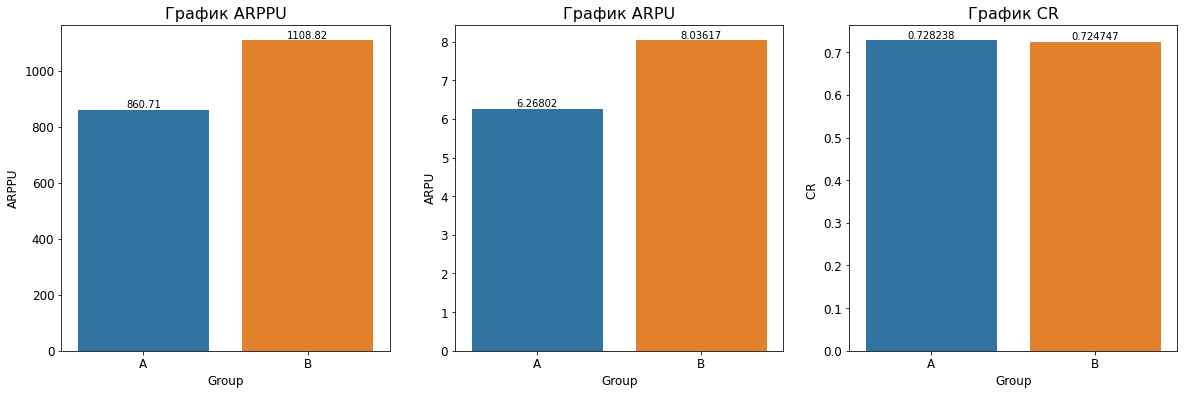

In [82]:
# вызов функции для визуализации
metrics_charts(result_metrics)